In [17]:
import pandas as pd
import numpy as np
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import evaluate
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


<h1>Functions</h1>

In [18]:
def create_label(row):
  if row['intentClass'] == 'E' or row['intentClass'] == 'I':
    return 1  # TOXIC
  else:
    return 0  # NON-TOXIC

<h1>Exploration & Preprocessing</h1>

Datasets

In [19]:
train_df = pd.read_csv("CONDA_train.csv")
valid_df = pd.read_csv("CONDA_valid.csv")

Pandas mods

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
train_df.head(20) 

,Id,matchId,conversationId,utterance,chatTime,playerSlot,playerId,intentClass,slotClasses,slotTokens
0,11263,697,3193,wow!,76,0,ANTS IN MY EYES JOHNSON,O,O,"wow (O),"
1,13741,843,3809,WTF,1563,5,M.k,O,T,"WTF (T),"
2,22125,1412,6199,wpe wpe,2853,1,Acqua Ragia,O,O O,"wpe (O), wpe (O),"
3,6453,439,1875,hahaha,1038,0,juicebox,O,O,"hahaha (O),"
4,9644,601,2713,wtf,1661,5,KAIST.Shadows,O,T,"wtf (T),"
5,6208,433,1836,i cant [SEPA] play [SEPA] with 4 trash,1674,6,Vintage <3,E,P O SEPA O SEPA O O O,"i (P), cant (O), [SEPA] (SEPA), play (O), [SEP..."
6,38968,2572,10979,bg,2875,8,Sirotax,O,O,"bg (O),"
7,3213,240,999,=) [SEPA] ty,1797,1,Иром,O,O,"#ERROR! (O),"
8,44326,3001,12737,gg [SEPA] report my team rat [SEPA] please,2602,7,ArielexD_Pro!!!,A,S SEPA S P O S SEPA O,"gg (S), [SEPA] (SEPA), report (S), my (P), tea..."
9,30888,2020,8676,ez mid,3044,8,Hanhan/~,I,S S,"ez (S), mid (S),"


In [21]:
print(f"Original train rows: {len(train_df)}")
train_df = train_df.dropna(subset=['utterance', 'intentClass'])
print(f"Train rows after dropping NaNs: {len(train_df)}")

print(f"Original valid rows: {len(valid_df)}")
valid_df = valid_df.dropna(subset=['utterance', 'intentClass'])
print(f"Valid rows after dropping NaNs: {len(valid_df)}")

Original train rows: 26921
Train rows after dropping NaNs: 26914
Original valid rows: 8974
Valid rows after dropping NaNs: 8973


In [22]:
train_df['label'] = train_df.apply(create_label, axis=1)
valid_df['label'] = valid_df.apply(create_label, axis=1)

/state/partition1/job-1572777/ipykernel_3642258/1064375072.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['label'] = train_df.apply(create_label, axis=1)


In [23]:
print("Train set label distribution:")
print(train_df['label'].value_counts(normalize=True))
print(train_df['label'].value_counts())

print("\nValidation set label distribution:")
print(valid_df['label'].value_counts(normalize=True))
print(valid_df['label'].value_counts())

Train set label distribution:
label
0    0.806049
1    0.193951
Name: proportion, dtype: float64
label
0    21694
1     5220
Name: count, dtype: int64

Validation set label distribution:
label
0    0.803299
1    0.196701
Name: proportion, dtype: float64
label
0    7208
1    1765
Name: count, dtype: int64


<h1>Training / Testing </h1>

<h4>Baseline 1 (TF-IDF + Logistic Regression)</h4>

In [24]:
# Training set
X_train, y_train = train_df['utterance'], train_df['label']

# Test set
X_test, y_test = valid_df['utterance'], valid_df['label']

In [25]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=20000)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [26]:
model_lr = LogisticRegression(max_iter=1000).fit(X_train_tfidf, y_train)
y_pred_lr = model_lr.predict(X_test_tfidf)

print("\nResults for TF-IDF + Logistic Regression (on validation set):")
print(classification_report(y_test, y_pred_lr, target_names=['NON-TOXIC (0)', 'TOXIC (1)']))


Results for TF-IDF + Logistic Regression (on validation set):
               precision    recall  f1-score   support

NON-TOXIC (0)       0.93      0.99      0.96      7208
    TOXIC (1)       0.94      0.69      0.80      1765

     accuracy                           0.93      8973
    macro avg       0.93      0.84      0.88      8973
 weighted avg       0.93      0.93      0.93      8973




--- Visualizing TF-IDF vectors with t-SNE ---
This may take a few minutes...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.013s...
[t-SNE] Computed neighbors for 5000 samples in 2.003s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.083130
[t-SNE] KL divergence after 300 iterations: 2.444008
Plotting results...


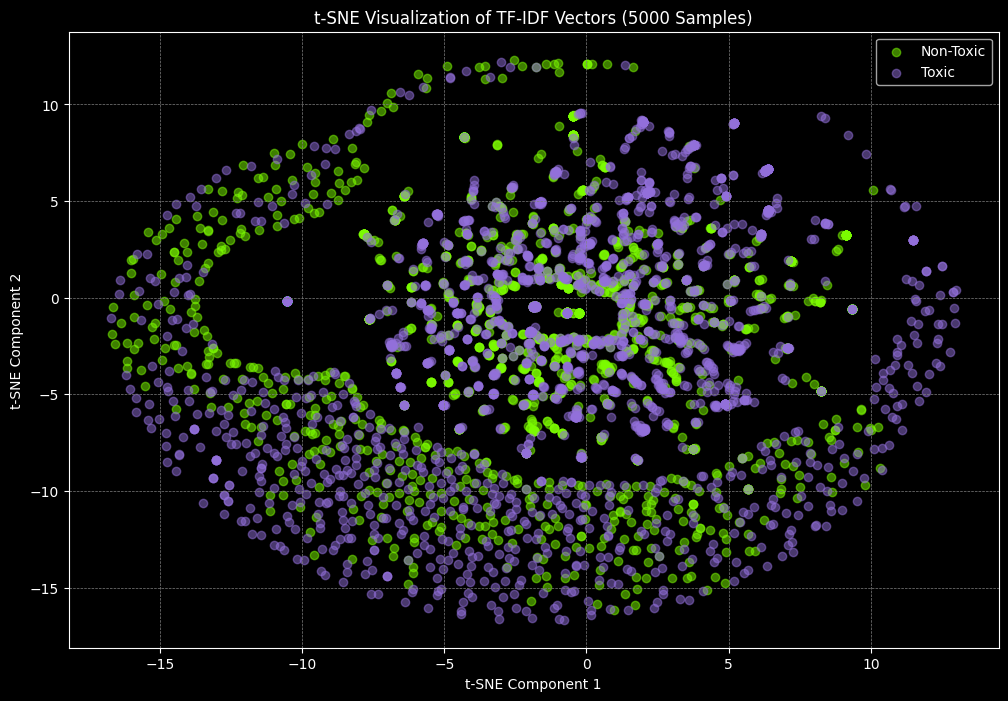

In [35]:
# -----------------------------------------------------------------
# Cell 4.5: NEW - Visualize TF-IDF Vectors with t-SNE
# -----------------------------------------------------------------
print("\n--- Visualizing TF-IDF vectors with t-SNE ---")
print("This may take a few minutes...")

# t-SNE is slow. Let's take a random sample of 5000 points to plot.
N_SAMPLES = 5000
# Ensure we get a mix of toxic and non-toxic samples
toxic_samples = train_df[train_df['label'] == 1].sample(n=N_SAMPLES//2, random_state=42)
non_toxic_samples = train_df[train_df['label'] == 0].sample(n=N_SAMPLES//2, random_state=42)

# Combine them
sample_df = pd.concat([toxic_samples, non_toxic_samples])

# Use the *same* vectorizer we trained in Cell 4
# Note: We must use .transform(), NOT .fit_transform()
sampled_X_tfidf = vectorizer.transform(sample_df['utterance'])
sampled_y = sample_df['label']

# Initialize t-SNE
# n_iter=300 is a good setting for a quick plot. verbose=1 shows progress.
tsne = TSNE(n_components=2, perplexity=30, max_iter=300, random_state=42, verbose=1)

# Run t-SNE. We use .toarray() to convert the sparse matrix to a dense one
tsne_results = tsne.fit_transform(sampled_X_tfidf.toarray())

print("Plotting results...")

# Plot the 2D results
plt.figure(figsize=(12, 8))
#plt.style.use('dark_background')
#plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
colors = {0: 'lawngreen', 1: 'mediumpurple'}
labels = {0: 'Non-Toxic', 1: 'Toxic'}

# Plot Non-Toxic points
plt.scatter(
    tsne_results[sampled_y == 0, 0], 
    tsne_results[sampled_y == 0, 1], 
    c=colors[0], 
    label=labels[0], 
    alpha=0.5
)

# Plot Toxic points
plt.scatter(
    tsne_results[sampled_y == 1, 0], 
    tsne_results[sampled_y == 1, 1], 
    c=colors[1], 
    label=labels[1], 
    alpha=0.5
)

plt.title('t-SNE Visualization of TF-IDF Vectors (5000 Samples)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

<h4>Baseline 2 (Fine-tuned BERT)</h4>

In [12]:
# 1. Load Tokenizer
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# 2. Convert pandas DataFrames to Hugging Face Dataset objects
# We only need the two columns we created
train_dataset = Dataset.from_pandas(train_df[['utterance', 'label']])
valid_dataset = Dataset.from_pandas(valid_df[['utterance', 'label']])

# 3. Rename 'utterance' to 'text' (this is often expected by the Trainer)
train_dataset = train_dataset.rename_column("utterance", "text")
valid_dataset = valid_dataset.rename_column("utterance", "text")

# 4. Tokenize the datasets
def tokenize_function(examples):
  return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_valid = valid_dataset.map(tokenize_function, batched=True)

print("Data tokenized and ready for BERT.")

# 5. Define metrics for evaluation
# We will get F1, Precision, and Recall for the TOXIC class (pos_label=1)
metric_f1 = evaluate.load("f1")
metric_precision = evaluate.load("precision")
metric_recall = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    f1 = metric_f1.compute(predictions=predictions, references=labels, pos_label=1)['f1']
    precision = metric_precision.compute(predictions=predictions, references=labels, pos_label=1)['precision']
    recall = metric_recall.compute(predictions=predictions, references=labels, pos_label=1)['recall']
    
    return {
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

Map: 100%|██████████| 8973/8973 [00:02<00:00, 4225.28 examples/s]


Data tokenized and ready for BERT.


In [14]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# model output in a directory called 'bert-results'
training_args = TrainingArguments(
    output_dir="bert-results_32",
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",     
    save_strategy="epoch",
    load_best_model_at_end=True,     
    report_to="none"                 # Disables wandb/comet logging
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
    compute_metrics=compute_metrics,
)


trainer.train()

print("\nFinal Results for Fine-tuned BERT (on validation set):")
eval_results = trainer.evaluate(tokenized_valid)
print(eval_results)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.223300,0.182207,0.855372,0.892791,0.820963
2,0.140500,0.172190,0.858837,0.855937,0.861756
3,0.096800,0.195656,0.862099,0.880165,0.844759



Final Results for Fine-tuned BERT (on validation set):


{'eval_loss': 0.17219007015228271, 'eval_f1': 0.8588368153585545, 'eval_precision': 0.8559369724254361, 'eval_recall': 0.861756373937677, 'eval_runtime': 92.6451, 'eval_samples_per_second': 96.854, 'eval_steps_per_second': 3.033, 'epoch': 3.0}


<b>RESULTS:</b>

<b>BERT batch_size = 16, epochs = 3</b>
 {'eval_loss': 0.17824195325374603, 'eval_f1': 0.8606774668630339, 'eval_precision': 0.896319018404908, 'eval_recall': 0.8277620396600567, 'eval_runtime': 94.5739, 'eval_samples_per_second': 94.878, 'eval_steps_per_second': 5.932, 'epoch': 3.0}

<b>BERT batch_size = 16, epochs = 3</b>
{'eval_loss': 0.17219007015228271, 'eval_f1': 0.8588368153585545, 'eval_precision': 0.8559369724254361, 'eval_recall': 0.861756373937677, 'eval_runtime': 92.6451, 'eval_samples_per_second': 96.854, 'eval_steps_per_second': 3.033, 'epoch': 3.0}    8973

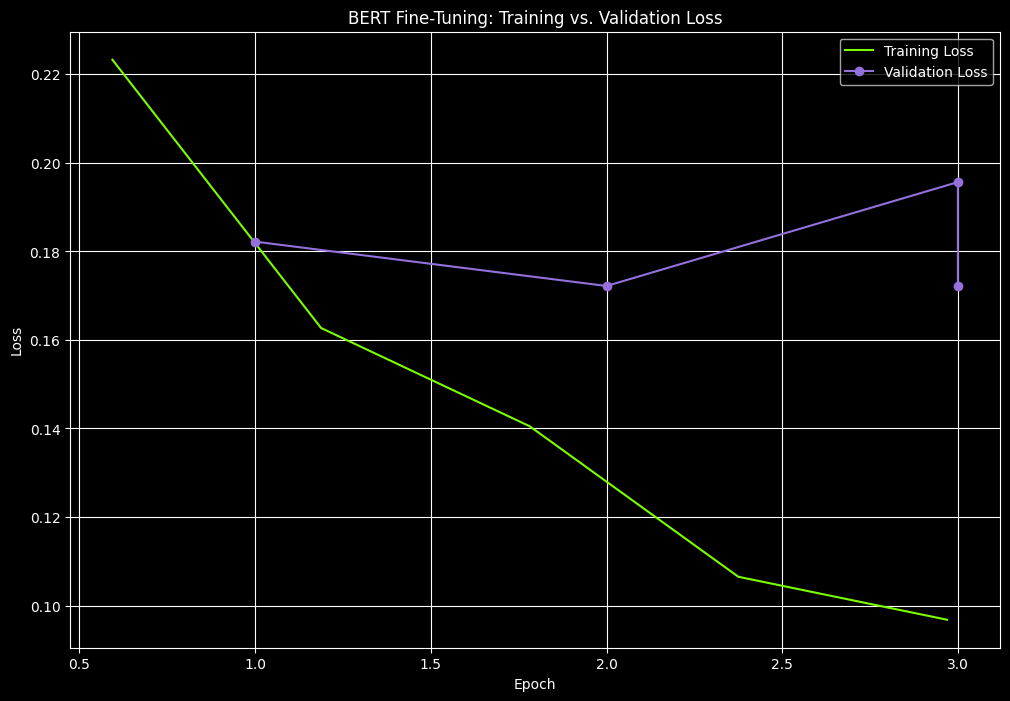

In [37]:
log_history = trainer.state.log_history
log_df = pd.DataFrame(log_history)

# Separate training loss from validation loss
train_logs = log_df[log_df['loss'].notna()].dropna(subset=['loss'])
valid_logs = log_df[log_df['eval_loss'].notna()].dropna(subset=['eval_loss'])

# Plot the losses
plt.figure(figsize=(12, 8))
#plt.style.use('dark_background')
#plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.plot(train_logs['epoch'], train_logs['loss'], label='Training Loss', color='lawngreen')
plt.plot(valid_logs['epoch'], valid_logs['eval_loss'], label='Validation Loss', marker='o', color='mediumpurple')

plt.title('BERT Fine-Tuning: Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()